# RFID Radio Propagation Analytics
This notebook is aimed to demostrate physical computation that is used for Bit Error Probability (BER) evaluation.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from pyrfidphy import channel_new as ch

### Parameters initialization
Here are the parameters of the model, which are as follows:
 * radio media (environment) parameters;
 * parameters of reader antenna system;
 * parameters of tag antenna system.

In [2]:
# environment parameters
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wavelen = speed_of_light / frequency
thermal_noise = -116 #dBm
permittivity = 15
conductivity = 0.03

preamble_duration=825e-6
symbol_duration=4.6875e-6
miller=4
bandwidth=1.2e6

# reader paramters
reader_height = 5.0 #m
reader_tx_power = 31.5 #dBm
reader_antenna_angle  = np.pi/4
reader_antenna_gain = 6 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 

# tag parameters
tag_speed = 20 #mps
tag_height = 0.5 #m
tag_antenna_angle  = np.pi/2
tag_antenna_gain = 2 #dBi 
tag_modulation_loss = -12.0 #dB
# tag_sensitivity=-17.5 #dBm
tag_sensitivity=-25 #dBm

# mutual parameters
polarization_loss = -3.0 #dB
ceil_height = 6

### Wrappers for functions computing antenna radiation pattern (RP) and reflection coefficients.

Radiation pattern for a patch antenna $L \times W$:

$$ \Gamma(\theta, \phi) = \left| 
	\frac{\sin{kW\sin{\theta}\sin{\phi}}}{kW\sin{\theta}\sin{\phi}}
		\cos{kL\sin{\theta}\cos{\phi}} \right| \times
		\sqrt{\cos^2{\phi} + \cos^2{\theta}\sin^2{\phi}}, $$

where $\theta$ is an elevating angle, and a reader antenna, $\phi$ is an azimuth angle, $k$ is a wave number.

Reflection coefficient is given by the following formula:

$$ R = \frac{\sin\phi - \sqrt{C}}{\sin\phi + \sqrt{C}} $$

where $\phi$ is a grazing angle, $C$ defined by the following expression:

$$ C = \eta - \cos^2\phi \text{ for horizontal polarization,} $$
$$ C = \frac{\eta - \cos^2\phi}{\eta^2} \text{for vertical one.} $$ 

$$\eta = \epsilon_r(f)-j60\lambda\sigma(f), $$

where $\epsilon_r(f)$ is a relative permittivity of a ground surface at the frequency $f$, $\sigma(f)$ is a conductivity.

In [3]:
def rp_patch(theta, phi):
    return ch.rp_patch(a_cos=np.cos(theta), t_cos=np.cos(phi), wavelen=wavelen, width=wavelen/2, length=wavelen/2)

def reflection(angle, polarization, permittivity, conductivity): 
    return [np.abs(ch.reflection(
        cosine=np.cos(t), polarization=polarization, permittivity=permittivity, 
        conductivity=conductivity, wavelen=wavelen)) for t in angle]

### Path loss and Link budget computation

Path loss is computated in assuption of multi-ray propagation media, presence of movement leading to Doppler's effect consideration, antennas radiation patterns and cmoplex reflection coefficient. The formula obtained are as follows:

$$
A_{pl} = \left(\frac{\lambda}{4\pi}\right)^2
	\left|\sum\limits_{i=0}^{N} \frac{R_i\Gamma_i}{d_i} 
		e^{-jk(d_i-\upsilon t \cos{\psi_i})}\right|^2, $$

where $c$ is a speed of light, $\upsilon$ is a relative speed of a receiver, $\psi_i$ is an angle between the wave vector $\vec{k_i}$ of $i$-th ray and the direction of movement, $\lambda$ is a wave length, $d_i$ is a length of $i$-th path, $R_i$ is a reflection coefficient of $i$-th ray (for line-of-sight ray we assumed $R_0 = 1$) and $\Gamma_i = \Gamma_i^{(r)}\Gamma_i^{(t)}$ is a coefficient correspond to a reader and a tag antenna radiation patterns properly.

For the presence computation a  number of rays $N$ equals to 1, thus the formula modulate two-ray propagation wih one reflected component, non line-of-site (NLoS) and LoS component.


The power received from the reader at the tag side is:

$$ P_r^{(t)} = P_t^{(r)} G^{(r)} A_{pl}^{(d)} A_{pol} G^{(t)}, $$

where $P_t^{(r)}$ is a reader transmission power, $G^{(r)}$ is an antenna gain, $A_{pl}^{(d)}$ is a path loss attenuation, $A_{pol}$ is a polarization loss, $G^{(t)}$ is a tag antenna has gain. If this power is lower the tag sensitivity $P_s^{(t)}$ the tag does not power up and will not able to communicate with the reader. Otherwise the tag modulate a backscattering signal $P_t^{(t)}$. The signal received at the reader side is:

$$ P_r^{(r)} = P_r^{(t)} G^{(t)} A_{bs} A_{pl}^{(r)} A_{pol} G^{(r)}, $$

where $A_{bs}$ is a backscattering loss caused by modulation loss, impedance mismatch, etc.

In [4]:
# Wrapper of 2-ray pathloss model 
def two_ray_pathloss(distance, time, speed, polarization):

    return ch.two_ray_pathloss(
        time=time, 
        
        ground_reflection=ch.reflection, 
        wavelen=wavelen,
        width=wavelen / 2,
        length=wavelen / 2,
        polarization=polarization, 
        permittivity=permittivity, 
        conductivity=conductivity,
        
        tx_pos=ch.vec3D(0, 0, reader_height), 
        tx_dir_theta=ch.vec3D(np.sin(reader_antenna_angle), 0, -np.cos(reader_antenna_angle)), 
        tx_dir_phi=ch.vec3D(0,1,0), 
        tx_velocity=ch.vec3D(0,0,0), 
        tx_rp=ch.rp_dipole,
        
        rx_pos=ch.vec3D(distance, 0, tag_height),
        rx_dir_theta=ch.vec3D(-np.sin(tag_antenna_angle), 0, np.cos(tag_antenna_angle)), 
        rx_dir_phi=ch.vec3D(0,-1,0), 
        rx_velocity=ch.vec3D(-speed,0,0), 
        rx_rp=ch.rp_dipole,
        log=True)

# Link budget computation function
def rx_power_tag(pathloss):
    return (reader_tx_power + reader_antenna_gain + reader_cabel_loss + 
            pathloss + tag_antenna_gain + polarization_loss)

def tx_power_tag(rx_power_tag):
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise

def rx_power_reader(pathloss, tx_power_tag):    
    return (tx_power_tag + tag_antenna_gain + pathloss + polarization_loss +
                reader_cabel_loss + reader_antenna_gain) if tx_power_tag >= reader_noise else thermal_noise


def rx_power_tag_full(distance, time, speed):
    pathloss_fwd = two_ray_pathloss(distance, time, speed, 0.5)
    return rx_power_tag(pathloss_fwd)

def tx_power_tag_full(distance, time, speed):
    rx_power_tag = rx_power_tag_full(distance, time, speed)
    return tx_power_tag(rx_power_tag)

def rx_power_reader_full(distance, time, speed):
    pathloss_fwd_ = two_ray_pathloss(distance, time, speed, .5)  # computing path loss from reader to tag 
    rx_power_tag_ = rx_power_tag(pathloss_fwd_)                  # computing RX power at tag
    tx_power_tag_ = tx_power_tag(rx_power_tag_)                  # computing TX power of tag
    pathloss_bwd_ = two_ray_pathloss(distance, time, speed, 1.)  # computing path loss from tag to reader
    return rx_power_reader(pathloss_bwd_, tx_power_tag_)

def ber_full(distance, time, speed):
    rx_power = rx_power_reader_full(distance, time, speed)
    snr = ch.snr(rx_power, reader_noise)
    snr_full = ch.snr_full(snr=snr, 
                           preamble=preamble_duration, 
                           symbol=symbol_duration, 
                           miller=miller, 
                           bandwidth=1.2e6)
    return ch.ber(snr=snr_full)

Here are computation of the antenna gain obtained from the specific radiation pattern given.

### Further different computation examples are presented

Examples of reflection coefficient computation versus different angles.

<IPython.core.display.Javascript object>


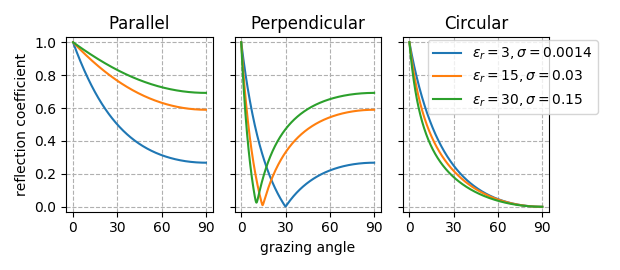

In [45]:
plt.figure(figsize=(6.2, 2.7))

ax = [0] * 3
for i, title in enumerate(['Parallel', 'Perpendicular', 'Circular']):

    ax[i] = plt.subplot2grid((1,10), (0,3*i), colspan=3)
    ax[i].set_title(title)
    ax[i].set_xticks(np.arange(4) * 30)
    ax[i].set_yticks(np.arange(6) / 5.)
    ax[i].grid(linestyle='--')

label = "$\epsilon_{{r}}={}, \sigma={}$"
angle = np.linspace(0.0, np.pi/2, 500)

for i, (perm, cond) in enumerate([(3, .0014), (15, .03), (30, .15),]):

    ax[0].plot(angle * 180 / np.pi, reflection(angle, 1., perm, cond))
    ax[1].plot(angle * 180 / np.pi, reflection(angle, .0, perm, cond))
    ax[2].plot(angle * 180 / np.pi, reflection(angle, .5, perm, cond), 
             label=label.format(perm, cond))    

ax[0].set_ylabel('reflection coefficient')
ax[1].set_xlabel('grazing angle')
ax[1].set_yticklabels([])
ax[2].set_yticklabels([])
for i in [0,1,2]: 
    ax[i].set_ybound(lower=-0.03, upper=1.03) 

plt.tight_layout()
plt.legend(loc=(0.17, 0.56))
plt.show()
plt.savefig('img/reflection.eps')

Example of path loss computation.

<IPython.core.display.Javascript object>


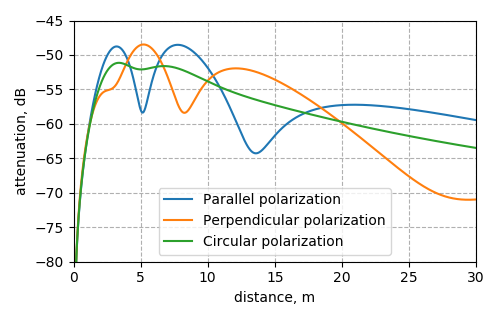

In [110]:
distance = np.linspace(0., 30, 1000)
pathloss = lambda p: [two_ray_pathloss(d, 0.0, 0, p) for d in distance] 

plt.figure(figsize=(5., 3.2))

for p, pstr in zip([1., .0, .5], ['Parallel', 'Perpendicular', 'Circular']):
    plt.plot(distance, pathloss(p), label=pstr + ' polarization')

plt.grid(linestyle='--')
plt.ylim((-80, -45))
plt.xlim((0, 30))

plt.ylabel('attenuation, dB')
plt.xlabel('distance, m')

plt.legend()
plt.tight_layout()
plt.savefig('img/pathloss_cases.eps')

Example of BER computation.

<IPython.core.display.Javascript object>


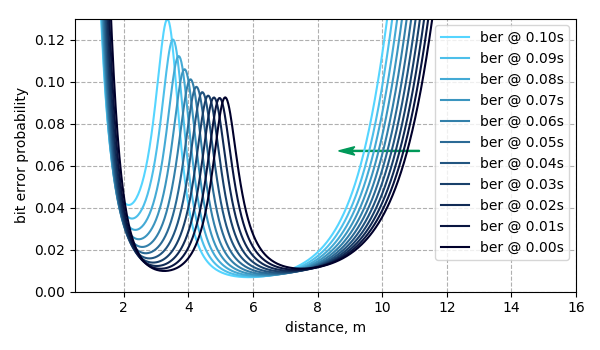

In [50]:
nplot = 11
distance  = np.linspace(.5, 15, 500)

ber   = lambda t: [ber_full(d, t, 60/3.6) for d in distance]
color = lambda i: (i/(nplot-1)/3, i/(nplot-1)/1.2, (i+2)/(nplot+1))
label = lambda t: 'ber @ {:.2f}s'.format(t)

miller=4
plt.figure(figsize=(6, 3.5))
plt.arrow(11.15, .067, -2., 0., width=.0005, head_width=0.004, head_length=0.5,
          overhang=0.2, color=(0,.6,.35))

for i in nplot - 1 - np.arange(nplot):
    plt.plot(distance, ber(.01*i), color=color(i), label=label(.01*i))

plt.ylim((0, .13))
plt.xlim((0.5, 16))
plt.ylabel('bit error probability')
plt.xlabel('distance, m')

plt.grid(linestyle='--')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('img/ber_doppler.eps')

<IPython.core.display.Javascript object>


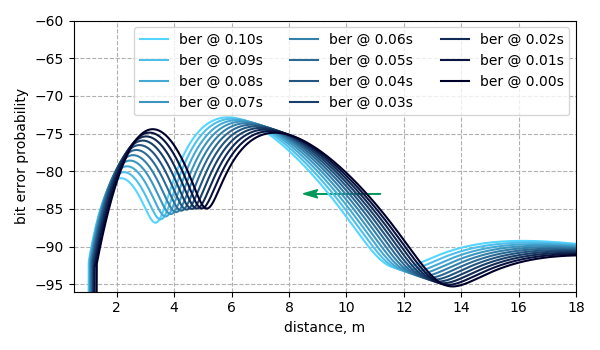

In [52]:
nplot = 11
distance  = np.linspace(.5, 18, 500)

ber   = lambda t: [rx_power_reader_full(d, t, 60/3.6) for d in distance]
color = lambda i: (i/(nplot-1)/3, i/(nplot-1)/1.2, (i+2)/(nplot+1))
label = lambda t: 'ber @ {:.2f}s'.format(t)

plt.figure(figsize=(6, 3.5))

for i in nplot - 1 - np.arange(nplot):
    plt.plot(distance, ber(.01*i), color=color(i), label=label(.01*i))

# plt.yticks(np.arange(0.0, 0.13, 0.01))

plt.arrow(11.2, -83, -2.2, 0., head_width=1.1, head_length=0.5,
          overhang=0.2, color=(0,.6,.35))
plt.ylim((-96, -60))
plt.xlim((.5, 18))
plt.ylabel('bit error probability')
plt.xlabel('distance, m')

plt.grid(linestyle='--')
plt.legend(loc=1, ncol=3)
plt.tight_layout()
plt.savefig('img/reader_power_doppler.eps')

<IPython.core.display.Javascript object>


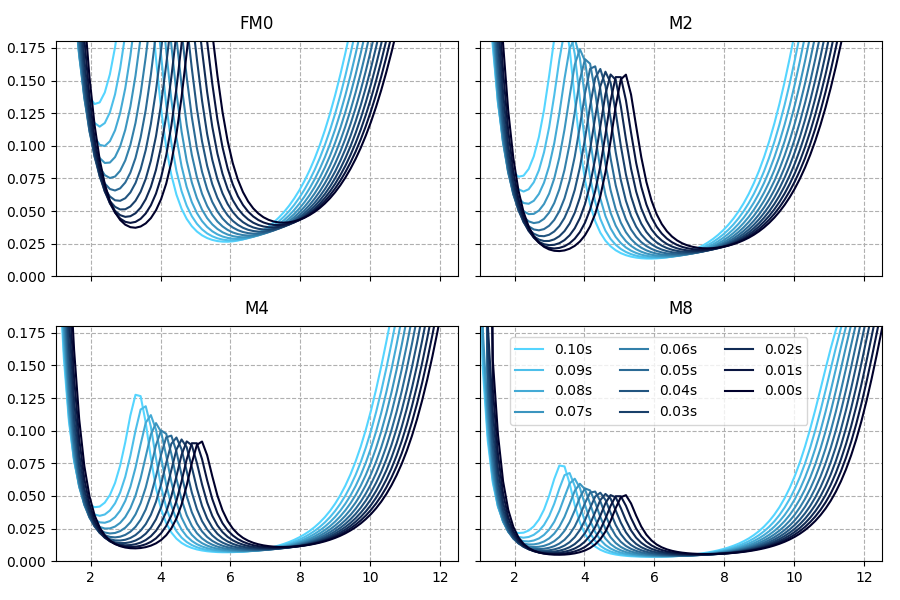

In [8]:
nplot = 11
distance  = np.linspace(.5, 15, 100)

encoding = {1: 'FM0', 2: 'M2', 4: 'M4', 8: 'M8'}
upper_bounds = [.25, .2, .15, .1]
ber   = lambda t: [ber_full(d, t, 60/3.6) for d in distance]
color = lambda i: (i/(nplot-1)/3, i/(nplot-1)/1.2, (i+2)/(nplot+1))
label = lambda t: '{:.2f}s'.format(t)

plt.figure(figsize=(9, 6))

ax = [0]*4
for i, m in enumerate([1,2,4,8]):
    
    ax[i] = plt.subplot2grid((2,2), (i // 2, i % 2))    
    ax[i].set_title(encoding[m], va='bottom')
    
    miller=m
    for j in nplot - 1 - np.arange(nplot):
        plt.plot(distance, ber(.01*j), color=color(j), label=label(.01*j))
        
    plt.grid(linestyle='--')

    plt.ylim((0, .18))
    plt.xlim((1., 12.5))

ax[3].legend(loc=(.075,.58), ncol=3)
ax[1].set_yticklabels([''])
ax[3].set_yticklabels([''])
ax[0].set_xticklabels([''])
ax[1].set_xticklabels([''])
plt.tight_layout()
# plt.savefig('ber_cases.eps')

<IPython.core.display.Javascript object>


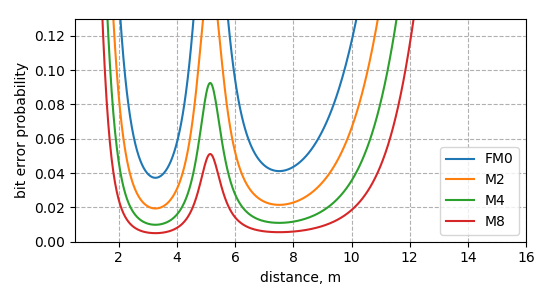

In [57]:
nplot = 11
distance  = np.linspace(.5, 15, 500)

ber   = lambda t: [ber_full(d, t, 60/3.6) for d in distance]
encoding = {1: 'FM0', 2: 'M2', 4: 'M4', 8: 'M8'}

miller = 2

plt.figure(figsize=(5.5, 3.))

for m in [1, 2, 4, 8]:
    miller = m
    plt.plot(distance, ber(.0), label=encoding[m])

# plt.yticks(np.arange(0.0, 0.13, 0.01))
plt.ylim((0, .13))
plt.xlim((0.5, 16))
plt.ylabel('bit error probability')
plt.xlabel('distance, m')

plt.grid(linestyle='--')
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('img/ber_miller.eps')

Pathloss and link bugdet parameters.

<IPython.core.display.Javascript object>


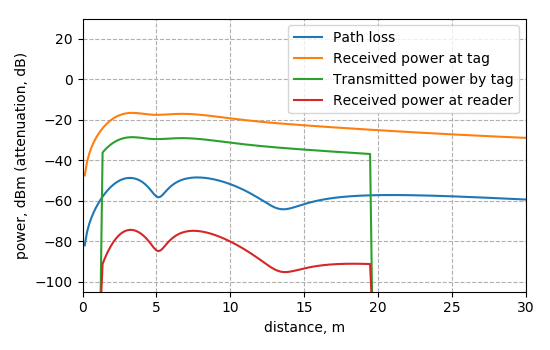

In [75]:
distance = np.linspace(0., 30, 200)

pathloss_b = [    two_ray_pathloss(d, 0.0,  0, 1) for d in distance]
rx_reader  = [rx_power_reader_full(d, .0, 60/3.6) for d in distance]
rx_tag     = [   rx_power_tag_full(d, .0, 60/3.6) for d in distance]
tx_tag     = [   tx_power_tag_full(d, .0, 60/3.6) for d in distance]

plt.figure(figsize=(5.5, 3.5))

plt.plot(distance, pathloss_b, label='Path loss')
plt.plot(distance, rx_tag,     label='Received power at tag')
plt.plot(distance, tx_tag,     label='Transmitted power by tag')
plt.plot(distance, rx_reader,  label='Received power at reader')

plt.ylim((-105,30))
plt.xlim((-0.,30))

plt.ylabel('power, dBm (attenuation, dB)')
plt.xlabel('distance, m')

plt.grid(linestyle='--')

plt.legend()
plt.tight_layout()
plt.savefig('img/link_budget.eps')

Computation on the grid for computation of parameters that ate as follows:
* power incident to tag;
* power incident to reader;
* path loss;
* BER over AWGN channel;
* BER over Rayleigh channel.

Next plots depicting the results are presented

In [103]:
distance = np.linspace(1, 10., 500)
time     = np.linspace(0, 2, 500)

def make_space_time_grid(distance, time, function, **kwargs):
    return np.array([[function(distance=d, time=t, **kwargs) for d in distance] for t in time])

pathloss_grid  = make_space_time_grid(distance, time, two_ray_pathloss,     speed=tag_speed, polarization=1)
rx_tag_grid    = make_space_time_grid(distance, time, rx_power_tag_full,    speed=tag_speed)
# rx_reader_grid = make_space_time_grid(distance, time, rx_power_reader_full, speed=tag_speed)
ber_grid       = make_space_time_grid(distance, time, ber_full,             speed=tag_speed)

<IPython.core.display.Javascript object>


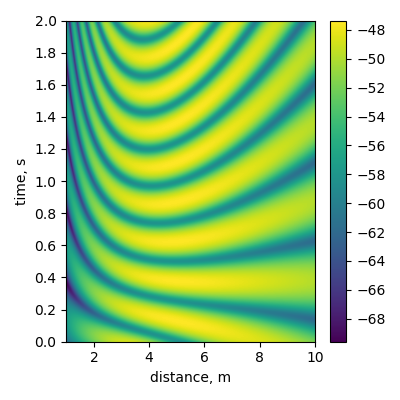

In [104]:
plt.figure(figsize=(4., 4.))

D,T = np.meshgrid(distance, time)
P = pathloss_grid

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-2 * np.arange(np.floor(P.max() - P.min()) / 2) + np.floor(P.max()))

im.axes.set_yticks(.2 * np.arange(11))
im.axes.set_xlabel('distance, m')
im.axes.set_ylabel('time, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
plt.savefig('img/pathloss.eps', dpi = 250, facecolor='w', edgecolor='w')

<IPython.core.display.Javascript object>


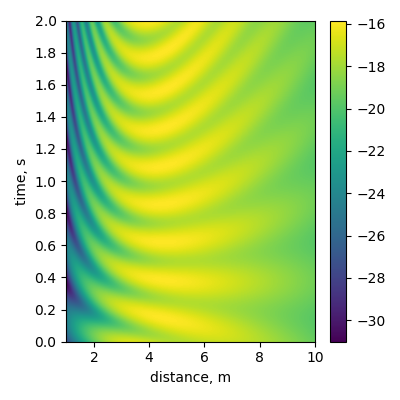

In [105]:
plt.figure(figsize=(4, 4))

D,T = np.meshgrid(distance, time)
P = rx_tag_grid

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-2 * np.arange(np.floor(P.max() - P.min()) / 2) + np.floor(P.max()))

im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m')
im.axes.set_ylabel('time, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
plt.savefig('img/rx_tag.eps', dpi = 250, facecolor='w', edgecolor='w')


<IPython.core.display.Javascript object>


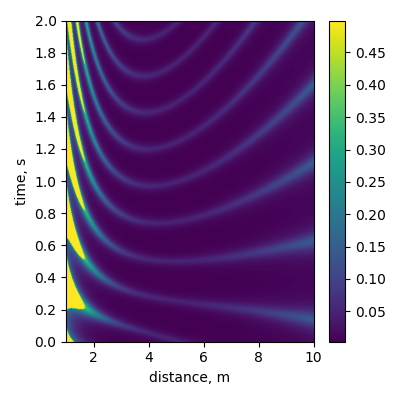

In [106]:
plt.figure(figsize=(4, 4))

D,T = np.meshgrid(distance, time)
P = ber_grid


im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=0.05 * np.arange(10))

im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m')
im.axes.set_ylabel('time, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
plt.savefig('img/ber.eps', dpi = 250, facecolor='w', edgecolor='w')

<IPython.core.display.Javascript object>


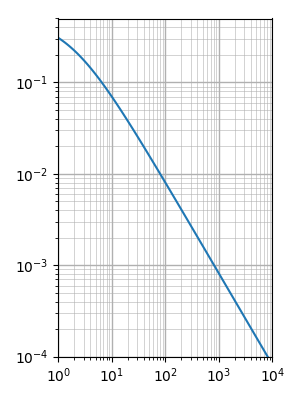

In [40]:
snr_ = [ch.from_log(db) for db in np.linspace(0, 40, 100)]
ber_ = [ch.ber(snr=snr_i) for snr_i in snr_]

plt.figure(figsize=(3, 4))

plt.loglog(snr_, ber_)

plt.ylim((1e-4, .5))
plt.xlim((.0, 1e4))
plt.grid(linewidth=.4, which='minor')
plt.grid(linewidth=1., which='major')

plt.tight_layout()
# plt.savefig('ber-plot.eps')

In [33]:
def two_ray_pathloss_angles(distance, time, speed, polarization, reader_angle, tag_angle):

    return ch.two_ray_pathloss(
        time=time, 
        
        ground_reflection=ch.reflection, 
        wavelen=wavelen,
        width=wavelen / 2,
        length=wavelen / 2,
        polarization=polarization, 
        permittivity=permittivity, 
        conductivity=conductivity,
        
        tx_pos=ch.vec3D(0, 0, reader_height), 
        tx_dir_theta=ch.vec3D(np.sin(reader_angle), 0, -np.cos(reader_angle)), 
        tx_dir_phi=ch.vec3D(0,1,0), 
        tx_velocity=ch.vec3D(0,0,0), 
        tx_rp=ch.rp_dipole,
        
        rx_pos=ch.vec3D(distance, 0, tag_height),
        rx_dir_theta=ch.vec3D(-np.sin(tag_angle), 0, np.cos(tag_angle)), 
        rx_dir_phi=ch.vec3D(0,-1,0), 
        rx_velocity=ch.vec3D(-speed,0,0), 
        rx_rp=ch.rp_dipole,
        log=True)

def rx_power_reader_full_angles(distance, time, speed, reader_angle, tag_angle):
    pathloss_fwd_ = two_ray_pathloss_angles(distance, time, speed, .5, reader_angle, tag_angle) 
    rx_power_tag_ = rx_power_tag(pathloss_fwd_)
    tx_power_tag_ = tx_power_tag(rx_power_tag_)
    pathloss_bwd_ = two_ray_pathloss_angles(distance, time, speed, 1., reader_angle, tag_angle)
    return rx_power_reader(pathloss_bwd_, tx_power_tag_)

def ber_full_angles(distance, time, speed, reader_angle, tag_angle):
    rx_power = rx_power_reader_full_angles(distance, time, speed, reader_angle, tag_angle)
    snr = ch.snr(rx_power, reader_noise)
    snr_full = ch.snr_full(snr=snr, 
                           preamble=preamble_duration, 
                           symbol=symbol_duration, 
                           miller=miller, 
                           bandwidth=1.2e6)
    return ch.ber(snr=snr_full)

In [159]:
reader_angle = np.linspace(0., np.pi/2, 100)
tag_angle    = np.linspace(0., np.pi/2, 100)

def make_angles_grid(reader_angle, tag_angle, function, **kwargs):
    return np.array([[function(reader_angle=r, tag_angle=t, **kwargs) for r in reader_angle] for t in tag_angle])

pathloss_abgles_grid = make_angles_grid(reader_angle, tag_angle, two_ray_pathloss_angles, 
                                        speed=tag_speed, polarization=1, distance=5, time=0.2)

<IPython.core.display.Javascript object>


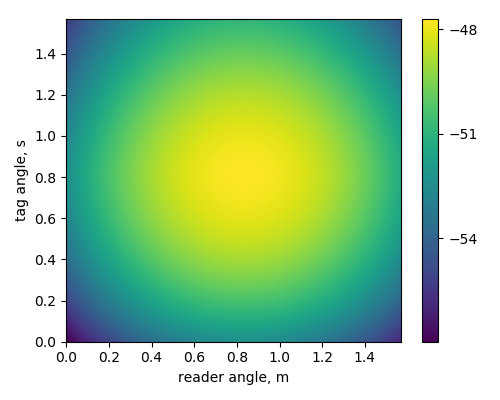

In [161]:
plt.figure(figsize=(5., 4.))

D,T = np.meshgrid(reader_angle, tag_angle)
P = pathloss_abgles_grid

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[0, np.pi/2, 0, np.pi/2])

cbar = plt.colorbar(ticks=-3 * np.arange(np.floor(P.max() - P.min()) / 3) + np.floor(P.max()))

# im.axes.set_yticks(.2 * np.arange(11))
im.axes.set_xlabel('reader angle, m')
im.axes.set_ylabel('tag angle, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
# plt.savefig('pathloss.eps', dpi = 250, facecolor='w', edgecolor='w')

In [158]:
reader_angle = np.linspace(0., np.pi/2, 60)
tag_angle    = np.linspace(0., np.pi/2, 60)

s_width = 12
s_height = 3

width = 60
height = 20

plt.figure(figsize=(s_width, s_height))

distance = np.linspace(2., 8, width)
time = np.linspace(0., .4, height)

from matplotlib import gridspec

gs = gridspec.GridSpec(height, width, width_ratios=[s_height/s_width]*width, wspace=0.0, hspace=0.0)

dt_max = np.zeros((height, width))

for i, d in enumerate(distance):
    for j, t in enumerate(time):

        ax= plt.subplot(gs[j,i])
        P = make_angles_grid(reader_angle, tag_angle, two_ray_pathloss_angles, polarization=1.,
                                            speed=tag_speed, distance=d, time=t)
        ax.imshow(P, aspect='auto', interpolation='gaussian',
                  origin='lower', extent=[0, np.pi/2, 0, np.pi/2])

        dt_max[j, i] = P.argmax() 
        
        ax.set_xticks([])
        ax.set_yticks([])

# plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
# plt.savefig('pathloss.eps', dpi = 250, facecolor='w', edgecolor='w')

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


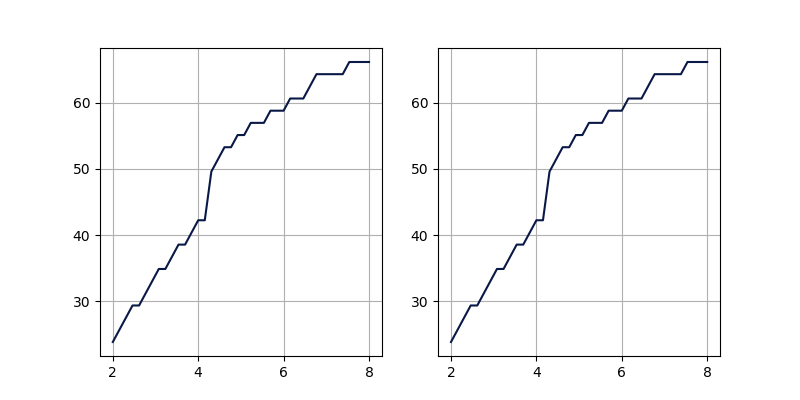

[  663.    714.    765.    816.    816.    867.    918.    969.    969.
  1020.   1071.   1071.   1122.   1173.   1173.   1373.9  1424.   1469.9
  1495.   1535.7  1531.   1551.6  1567.   1582.6  1603.   1623.4  1633.6
  1659.   1689.4  1699.6  1735.   1750.4  1755.6  1786.   1791.4  1796.4
  1806.6  1817.4  1827.4  1827.5]


In [157]:
plt.figure(figsize=(8,4))

ax0 = plt.subplot2grid((1,2), (0, 0))
ax1 = plt.subplot2grid((1,2), (0, 1))  

color = lambda i: (i/(nplot-1)/3, i/(nplot-1)/1.2, (i+2)/(nplot+1))
nplot = dt_max.shape[0]
# for i in range(2):
#     ax0.plot(distance, (dt_max[i] // P.shape[0]) * 90/49, color=color(i)) #reader
#     ax1.plot(distance, (dt_max[i] // P.shape[1]) * 90/49, color=color(i))

ax0.plot(distance, (dt_max.mean(axis=0) // P.shape[0]) * 90/49, color=color(i)) #reader
ax1.plot(distance, (dt_max.mean(axis=0) // P.shape[1]) * 90/49, color=color(i))
    
ax0.grid()
ax1.grid()
plt.show()


<IPython.core.display.Javascript object>


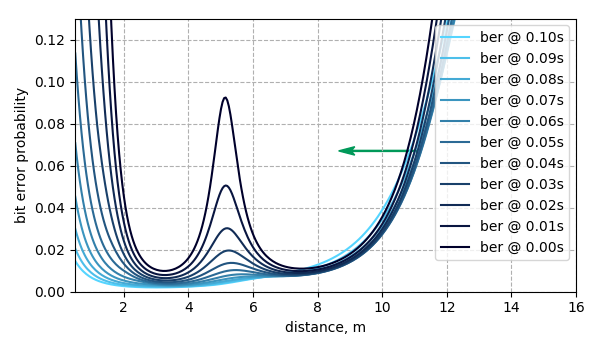

In [39]:
nplot = 11
distance  = np.linspace(.5, 15, 300)

def ber(time, reader_angle, tag_angle):
    
    return [ber_full_angles(d, time, 60/3.6, reader_angle, tag_angle) for d in distance]

    
color = lambda i: (i/(nplot-1)/3, i/(nplot-1)/1.2, (i+2)/(nplot+1))
label = lambda t: 'ber @ {:.2f}s'.format(t)

plt.figure(figsize=(6, 3.5))
plt.arrow(11.15, .067, -2., 0., width=.0005, head_width=0.004, head_length=0.5,
          overhang=0.2, color=(0,.6,.35))

for i in nplot - 1 - np.arange(nplot):
    plt.plot(distance, ber(.0, np.pi/4, np.pi/2*(1 - i/nplot/2)), color=color(i), label=label(.01*i))

plt.ylim((0, .13))
plt.xlim((0.5, 16))
plt.ylabel('bit error probability')
plt.xlabel('distance, m')

plt.grid(linestyle='--')
plt.legend(loc=1)
plt.tight_layout()

<IPython.core.display.Javascript object>


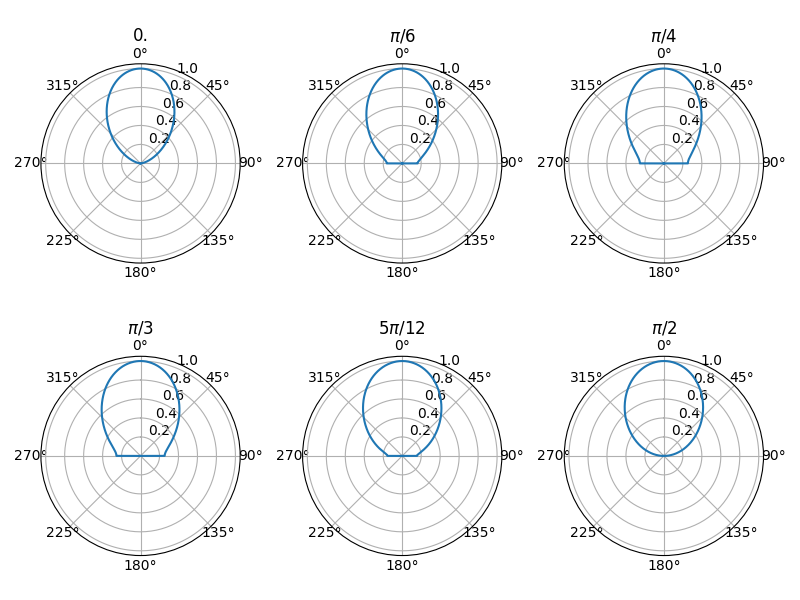

In [29]:
theta = np.linspace(-np.pi, np.pi, 1000)

plt.figure(figsize=(8,6))

angles     = [0., np.pi/6, np.pi/4, np.pi/3, np.pi/12*5, np.pi/2,]
angles_str = ['0.', '$\pi/6$', '$\pi/4$', '$\pi/3$', '$5\pi/12$', '$\pi/2$',]

for i, (angle, a_str) in enumerate(zip(angles, angles_str)):

    ax = plt.subplot2grid((2,3), (i // 3, i % 3), projection='polar')    

    ax.plot(theta, [rp_patch(t, angle) for t in theta])

    ax.set_theta_zero_location('N')
    ax.set_title(a_str, va='bottom')
    ax.set_theta_direction(-1)
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


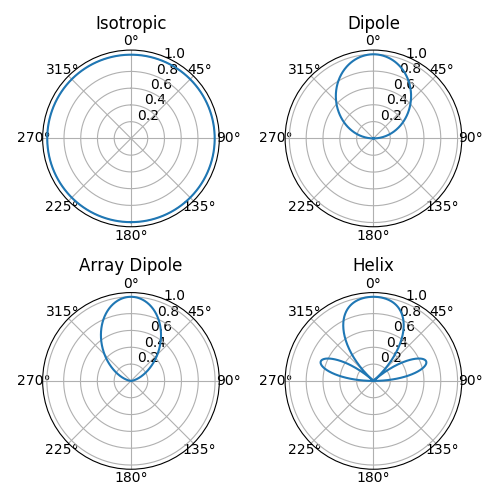

In [106]:
# theta = np.linspace(-np.pi, np.pi, 1000)

# plt.figure(figsize=(5,5))

# rps = [lambda t:    ch.isotropic_rp(a_cos=t), 
#        lambda t:       ch.dipole_rp(azimuth=t), 
#        lambda t: ch.array_dipole_rp(azimuth=t, n=2), 
#        lambda t:        ch.helix_rp(azimuth=t, n=3)]

# rps_str = ['Isotropic', 'Dipole', 'Array Dipole', 'Helix']

# for i, (rp, rp_str) in enumerate(zip(rps, rps_str)):

#     r = [rp(t) for t in theta]
    
#     ax = plt.subplot2grid((2,2), (i // 2, i % 2), projection='polar')    
#     ax.plot(theta, r)
#     ax.set_theta_zero_location('N')
#     ax.set_title(rp_str, va='bottom')
#     ax.set_theta_direction(-1)
    
# plt.tight_layout()
# plt.show()

In [6]:
# #
# # Antenna gain computation
# #
# def antenna_gain_(radiation_pattern, theta, **kwargs):
#     max_gain  = radiation_pattern(azimuth=0, **kwargs)
#     mean_gain = np.sum([radiation_pattern(azimuth=t, **kwargs) for t in theta]) / theta.size
#     return ch.lin2db(max_gain / mean_gain)

# def antenna_gain_2d_(radiation_pattern, theta, tilt, **kwargs):
#     max_gain  = radiation_pattern(0, tilt, **kwargs)
#     mean_gain = np.sum([radiation_pattern(t, tilt, **kwargs) for t in theta]) / theta.size
#     return ch.lin2db(max_gain / mean_gain)

# theta = np.linspace(-pi, pi, num=100)

# gain_iso = antenna_gain_(ch.isotropic_rp, theta)
# gain_dip = antenna_gain_(ch.dipole_rp, theta)
# gain_arr = antenna_gain_(ch.array_dipole_rp, theta, n=2)
# gain_hel = antenna_gain_(ch.helix_rp, theta, n=3)

# print(gain_iso, gain_dip, gain_arr, gain_hel)

# gain_patch_0 = antenna_gain_2d_(patch_rp_, theta, 0.0)
# gain_patch_1 = antenna_gain_2d_(patch_rp_, theta, pi/6)
# gain_patch_2 = antenna_gain_2d_(patch_rp_, theta, pi/4)
# gain_patch_3 = antenna_gain_2d_(patch_rp_, theta, pi/3)
# gain_patch_4 = antenna_gain_2d_(patch_rp_, theta, pi/12*5)

# print(gain_patch_0, gain_patch_1, gain_patch_2, gain_patch_3, gain_patch_4)

0.0 5.349029975306875 6.314535216429676 5.392705253793354
6.314535216429675 5.67962938579154 5.334393666807177 5.252871482124313 5.417786106090564
